## PyTorch VS PyTorch Lightning

**PyTorch Lightning** это фреймворк для организованной работы с **PyTorch**. В нем упрощена работа по:
- Написанию тренировочного цикла
- Написанию датасетов
- Использованию gpu/tpu/ipu/hpu и тд
- Переводу моделей в формат ONNX
- И многому другому

Фреймворк призван оставить юзеру возможность конфигурировать параметры и проводить эксперименты, а остальное он возьмет на себя. Давайте сравним код на **PyTorch** без и с использованием **Lightning** на примере несложной нейросети на датасете FashionMNIST.

In [ ]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# крутая библиотека с кучей метрик "из коробки"
from torchmetrics.functional import accuracy

### Данные (общее)

In [ ]:
# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

In [ ]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Ankle Boot


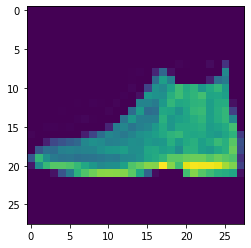

Coat


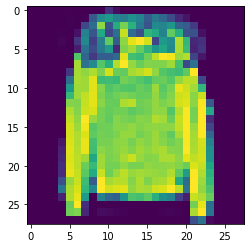

In [ ]:
### pictures are normalized
for batch in val_dataloader:
    # batch_size is 128
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    plt.show()
    break

### Модель (общее)

Создайте класс модели по следующей схеме:

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLu -> MaxPool(kernel=2)
3. BatchNorm
4. Conv(out=64, kernel=3) -> ReLu -> MaxPool(kernel=2)
5. Flatten
6. Linear(out=128)
7. ReLu
8. Dropout
9. Linear(out=64)
10. ReLu
11. Linear(out=10)

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm1 = torch.nn.BatchNorm2d(1)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)

        self.output = torch.nn.Linear(in_features=64, out_features=10)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=10)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Гиперпараметры

In [ ]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

### Тренировочные циклы (PyTorch)

Здесь нам надо будет объявить функции `train_epoch`, `validate`, `fit`.
Структура, напомним, выглядит, в упрощенном виде, так:
```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```
Но на деле это все намного сложнее:

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [ ]:
# проверим, что всё работает (±1 минута на гпу):
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=1,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.1868 Accuracy: 24.435: 100%|██████████| 469/469 [00:52<00:00,  8.95it/s] 
Validation Epoch: 0
Loss: 2.1573 Accuracy: 52.09: 100%|██████████| 79/79 [00:03<00:00, 21.25it/s]  


### Тренировочные циклы (Lightning)

Здесь будет немного другая структура.

1) Создается 1 класс отнаследованный от `pl.LightningModule`. В нем описывается сама модель, необходимые функции тренировчного и валидационного шага.

2) Создается объект класса `pl.Trainer` с параметрами (напр. номер гпу, кол-во эпох, град. клиппинг и так далее) дока [тут](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) или [тут](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `SimpleNet`, то исправлять нам много не надо.

In [ ]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # сохраняет логи в папку, но можно несложно добавить wandb
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [ ]:
# 2) create module

model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(module, train_dataloader, val_dataloader)

# 3.5) we can also find best learning rate like this: https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html
# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
# trainer.tune(module, train_dataloader, eval_dataloader)
# trainer.fit(module, train_dataloader, eval_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleNet | 232 K 
------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Обратите внимание **насколько** поведение `trainer.fit()` сильно похоже на написанную нами ранее функцию `fit()`


Заметьте также, что на Lightning мы:
1.   Не описывали тренировочный цикл ни по эпохам, ни по батчам
2.   Не рисковали забыть zero_grad, .backward()
3.   Не переносили ни модель, ни данные на GPU
4.   Получили всякие приколы типа auto_lr_find
5.   Сохранили возможность использования многих тонкостей **PyTorch** типа [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), логирование через [wandb](https://docs.wandb.ai/guides/integrations/lightning) и так далее